In [1]:
#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

Not running on Colab


In [122]:
# from gekko import GEKKO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape, Conv1DTranspose, Conv2DTranspose

from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [11]:
data = pd.read_pickle(path + 'MIMO_open_loop_data_3000.pkl')
data = pd.DataFrame(np.array(data).T, columns=['u1', 'u2', 'y1', 'y2'])

In [13]:
data["y1"][1:] = data["y1"][0:-1]
data["y2"][1:] = data["y2"][0:-1]

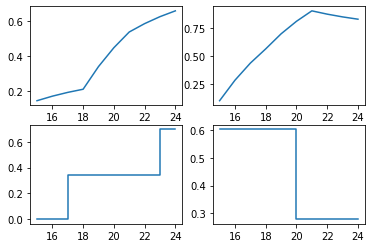

In [14]:
plt.figure(0)
plt.subplot(2,2,1)
plt.plot(data["y1"][15:25])
plt.subplot(2,2,2)
plt.plot(data["y2"][15:25])
plt.subplot(2,2,3)
plt.plot(data["u1"][15:25], drawstyle='steps')
plt.subplot(2,2,4)
plt.plot(data["u2"][15:25], drawstyle='steps')

plt.show()

## 4. Train LSTM Network

In [15]:
window = 5
P = 10

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['u1', 'u2', 'y1', 'y2']])
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['y1', 'y2']])

In [16]:
Ys.shape, Xs.shape

((3000, 2), (3000, 4))

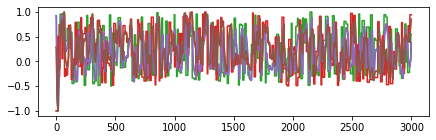

In [26]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [27]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window
model_params['P'] = P # prediction horizon

dump(model_params, open(path + 'model_param_MIMO.pkl', 'wb'))


In [29]:
nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

1500


## Preparing training data for simultaneous **multi-step** prediction
X_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:(\text{window + P})\: \times\: \text{Nvariables}}$  
Y_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:\text{P}\: \times\: \text{Nvariables}}$  


In [178]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)-P):
    X_train.append(Xs_train[i-window:i+P,:])
    Y_train.append(Ys_train[i:i+P])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)-P):
    X_val.append(Xs_val[i-window:i+P,:])
    Y_val.append(Ys_val[i:i+P])

In [179]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

## Replacing outputs in the prediction horizon ($\text y_{k+i}$) with the latest measured value ($\text y_k$)  , where, $i = 1, 2, ... ,\text P$

In [180]:
for i in range(0, len(X_train)):
  X_train[i][window:,2] = X_train[i][window-1,2]
  X_train[i][window:,3] = X_train[i][window-1,3]

for i in range(0, len(X_val)):
  X_val[i][window:,2] = X_val[i][window-1,2]
  X_val[i][window:,3] = X_val[i][window-1,3]

In [152]:
# Demension of training data set
# Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]*Y_train.shape[2]))
# Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]*Y_val.shape[2]))
np.shape(X_train), np.shape(Y_train)

((1485, 15, 4), (1485, 20))

In [181]:
X_train[15], Y_train[15]

(array([[-1.        ,  0.50932153, -1.        , -1.        ],
        [-1.        ,  0.50932153, -0.97116965, -0.79411104],
        [-1.        ,  0.50932153, -0.94714437, -0.6225369 ],
        [-0.13997244,  0.50932153, -0.92712329, -0.47955845],
        [-0.13997244,  0.50932153, -0.78320865, -0.32857701],
        [-0.13997244,  0.50932153, -0.78320865, -0.32857701],
        [-0.13997244, -0.30256961, -0.78320865, -0.32857701],
        [-0.13997244, -0.30256961, -0.78320865, -0.32857701],
        [-0.13997244, -0.30256961, -0.78320865, -0.32857701],
        [ 0.74395251, -0.30256961, -0.78320865, -0.32857701],
        [ 0.74395251, -0.30256961, -0.78320865, -0.32857701],
        [ 0.74395251, -0.30256961, -0.78320865, -0.32857701],
        [ 0.74395251, -0.30256961, -0.78320865, -0.32857701],
        [ 0.74395251, -0.30256961, -0.78320865, -0.32857701],
        [ 0.74395251, -0.30256961, -0.78320865, -0.32857701]]),
 array([[-0.66327978, -0.20275913],
        [-0.56333905, -0.0979109

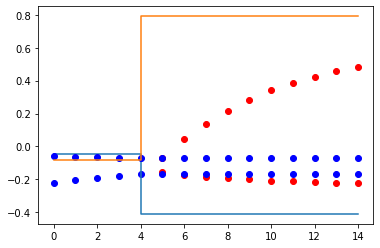

In [182]:
i = 155
t = np.linspace(0, 14, 15)
plt.plot(t[5:],Y_train[i],'ro')
plt.plot(t, X_train[i][:,2],'bo')
plt.step(t, X_train[i][:,0])
plt.plot(t, X_train[i][:,3],'bo')
plt.step(t, X_train[i][:,1])

In [183]:
Y_train[160]

array([[-0.20704839,  0.34050625],
       [-0.21259037,  0.3866839 ],
       [-0.21720868,  0.42516528],
       [-0.22105728,  0.45723309],
       [-0.22426444,  0.48395627],
       [-0.22693707,  0.50622558],
       [-0.26056608,  0.39907685],
       [-0.28859025,  0.30978623],
       [-0.31194372,  0.23537739],
       [-0.33140495,  0.17337002]])

In [65]:
X_train[160]

array([[-0.4096808 ,  0.79137596, -0.15755897, -0.07185645],
       [-0.4096808 ,  0.79137596, -0.17134918,  0.04304831],
       [-0.4096808 ,  0.79137596, -0.18284103,  0.13880229],
       [-0.4096808 ,  0.79137596, -0.19241757,  0.21859726],
       [-0.4096808 ,  0.79137596, -0.20039801,  0.28509307],
       [-0.4096808 ,  0.79137596, -0.20039801,  0.28509307],
       [-0.4096808 ,  0.79137596, -0.20039801,  0.28509307],
       [-0.4096808 ,  0.79137596, -0.20039801,  0.28509307],
       [-0.4096808 ,  0.79137596, -0.20039801,  0.28509307],
       [-0.4096808 ,  0.79137596, -0.20039801,  0.28509307],
       [-0.4096808 , -0.05570975, -0.20039801,  0.28509307],
       [-0.4096808 , -0.05570975, -0.20039801,  0.28509307],
       [-0.4096808 , -0.05570975, -0.20039801,  0.28509307],
       [-0.4096808 , -0.05570975, -0.20039801,  0.28509307],
       [-0.4096808 , -0.05570975, -0.20039801,  0.28509307]])

In [184]:
# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=False))
model_lstm.add(Dropout(0.2))
# model_lstm.add(Conv1DTranspose(kernel_size=1, filters=2, padding='valid')) #units = number of outputs
# model_lstm.add(Conv1DTranspose(kernel_size=1, filters=2, padding='valid')) #units = number of outputs
# model_lstm.add(Dropout(0.5))
model_lstm.add(tf.keras.layers.Flatten())
model_lstm.add(Dense(units=20))
model_lstm.add(Reshape((10, 2)))
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

In [185]:
model_lstm.summary()
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 32,\
                             callbacks=[es_lstm, TqdmCallback(verbose=1)],\
                             verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

# model_lstm.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_165 (LSTM)             (None, 15, 100)           42000     
                                                                 
 dropout_166 (Dropout)       (None, 15, 100)           0         
                                                                 
 lstm_166 (LSTM)             (None, 15, 100)           80400     
                                                                 
 dropout_167 (Dropout)       (None, 15, 100)           0         
                                                                 
 lstm_167 (LSTM)             (None, 100)               80400     
                                                                 
 dropout_168 (Dropout)       (None, 100)               0         
                                                                 
 flatten_2 (Flatten)         (None, 100)             

 19%|█▊        | 56/300 [02:01<10:14,  2.52s/epoch, loss=0.00205, accuracy=0.956, val_loss=0.000495, val_accuracy=0.977]

Epoch 56: early stopping


 19%|█▊        | 56/300 [02:01<08:51,  2.18s/epoch, loss=0.00205, accuracy=0.956, val_loss=0.000495, val_accuracy=0.977]

Runtime: 122.01 s


In [ ]:
#%% Save LSTM model file
# model_lstm.save(path + 'MPC_surrogate_SISO_FOPDT_multistep_LSTM.h5')

## 2. Transformer

In [ ]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window+P, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)


xl = tf.keras.layers.Flatten()(xl)
yl = tf.keras.layers.Dense(n_label, activation='linear')(xl)
model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
                               callbacks=[es_trans, TqdmCallback(verbose=1)], \
                               verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))

model_trans.summary()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00175: early stopping
Runtime: 60.06 s
Model: "mhl"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 2)]      0                                            
__________________________________________________________________________________________________
multi_head_attention_4 (MultiHe (None, 15, 2)        222         input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_4 (TFOpLam (None, 15, 2)        0           multi_head_attention_4[0][0]     
                                                                 input_3[0][0]                    
___________________________________________________

In [ ]:
#%% Save Transformer model file
# model_trans.save(path + 'MPC_surrogate_SISO_FOPDT_multistep_Transformer.h5')

Text(0.5, 0, 'Epochs')

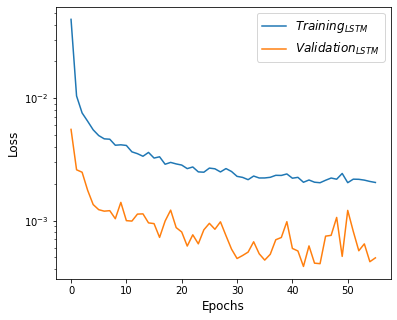

In [186]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
# plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
# plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

# plt.savefig(path + 'Loss_surrogate_SISO_FOPDT_multistep.eps', format='eps')

## 5. Using measured values to predict next step

### LSTM

In [ ]:
# # Load NN Models
# model_lstm = load_model(path + 'MPC_surrogate_SISO_FOPDT_LSTM.h5')
# model_trans = load_model(path + 'MPC_surrogate_SISO_FOPDT_Transformer.h5')

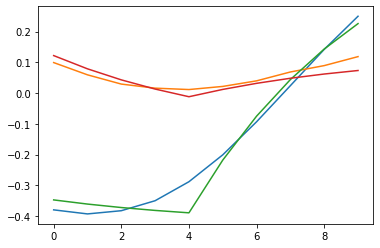

In [197]:
plt.plot(Yp_train_lstm[170])
plt.plot(Y_train[170])


NameError: name 'Ym_train' is not defined

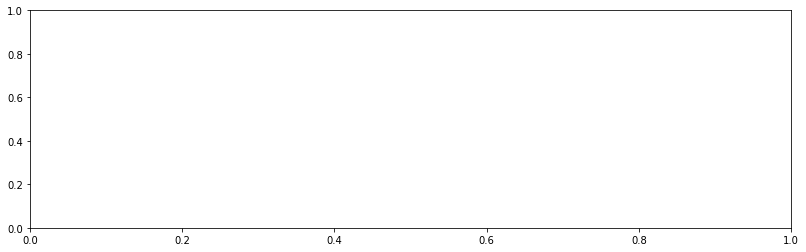

In [193]:
# Verify the fit of the model
Yp_train_lstm = model_lstm.predict(X_train)
Yp_val_lstm = model_lstm.predict(X_val)

# un-scale outputs
# Yu_train_lstm = s2.inverse_transform(Yp_train_lstm) # model prediction
# Ym_train = s2.inverse_transform(Y_train) # measured value

# Yu_val_lstm = s2.inverse_transform(Yp_val_lstm) # model prediction
# Ym_val = s2.inverse_transform(Y_val) # measured value


# Verify the fit of the model
# Yp_train_trans = model_trans.predict(X_train)
# Yp_val_trans = model_trans.predict(X_val)

# un-scale outputs
# Yu_train_trans = s2.inverse_transform(Yp_train_trans) # model prediction
# Ym_train = s2.inverse_transform(Y_train) # measured value

# Yu_val_trans = s2.inverse_transform(Yp_val_trans) # model prediction
# Ym_val = s2.inverse_transform(Y_val) # measured value




# plt.figure(0, figsize=(30,4))
# plt.subplot(1,2,1)
# plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
# plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,0],'g--',label='Transformer')

# plt.title('Training')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(data.index[cut_index+window:-P],Ym_val[:,0],'b-',label='Measured')
# plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,0],'r-',label='LSTM')
# plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,0],'g--',label='Transformer')
# plt.title('Validation')
# plt.legend()

# plt.figure(1, figsize=(30,4))
# plt.subplot(1,2,1)
# plt.plot(data.index[window:cut_index-P],Ym_train[:,4],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,4],'r-',label='LSTM')
# plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,4],'g--',label='Transformer')
# plt.title('Training')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(data.index[cut_index+window:-P],Ym_val[:,4],'b-',label='Measured')
# plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,4],'r-',label='LSTM')
# plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,4],'g--',label='Transformer')
# plt.title('Validation')
# plt.legend()



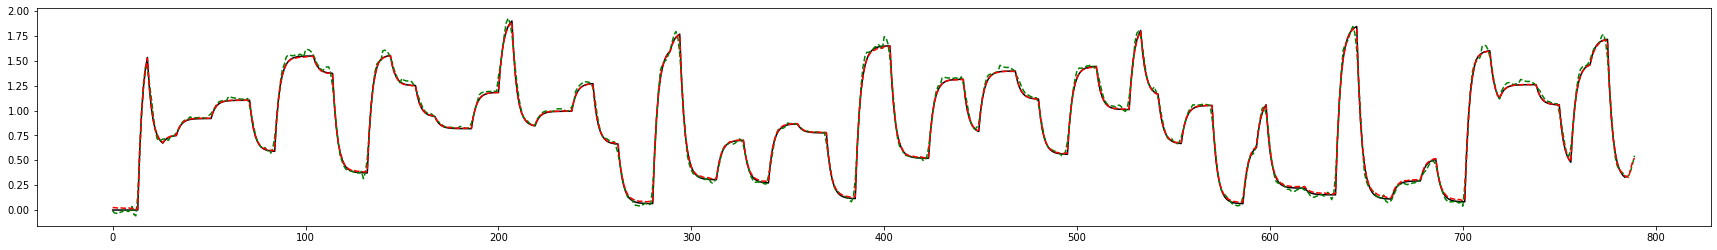

In [ ]:
# plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.figure(figsize=(30,4))
plt.plot(Ym_train[:,0], 'k-')
plt.plot(Y2, 'g--')
plt.plot(Y1,'r--',label='Transformer')



np.shape(Yu_train_trans[0:785:10])
Y1 = np.transpose(np.reshape(Yu_train_trans[0:785:10], (1,790)))
Y2 = np.transpose(np.reshape(Yu_train_lstm[0:785:10], (1,790)))
np.reshape()

No handles with labels found to put in legend.


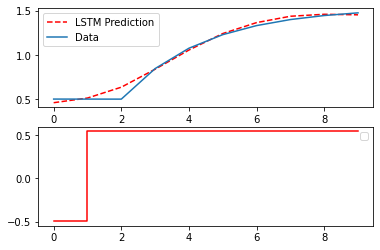

In [ ]:
j =210
plt.subplot(2,1,1)
plt.plot(Yu_val_lstm[j], 'r--', label='LSTM Prediction')
plt.plot(Ym_val[j], label='Data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(X_val[j][window:,0], 'r-', drawstyle = 'steps')
plt.legend()